<a href="https://colab.research.google.com/github/laura-caullo/DiploDatos2023/blob/main/ntb_clustering_2_fifa2019_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset

Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros...

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [ ]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [ ]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'.

In [ ]:
url='https://raw.githubusercontent.com/DiploDatos/AprendizajeNOSupervisado/master/2021/data.csv'

In [ ]:
df=pd.read_csv(url)

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [ ]:
n=10000
df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['Overall']>70)] # mejores jugadores

skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
                  'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
                  'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
                  'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                  'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                  'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
                  'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')

df_skills=df_n[skills_ratings]

34 variables numéricas: skills/habilidades


In [ ]:
df_skills #Entrada, matriz de datos X

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,64.0,62.0,54.0,72.0,56.0,72.0,68.0,64.0,69.0,70.0,66.0,59.0,68.0,71.0,66.0,66.0,31.0,67.0,73.0,64.0,52.0,51.0,73.0,72.0,66.0,62.0,31.0,54.0,41.0,4.0,4.0,4.0,4.0,4.0
4745,69.0,57.0,59.0,73.0,57.0,71.0,69.0,59.0,69.0,73.0,78.0,79.0,74.0,69.0,76.0,63.0,78.0,84.0,76.0,67.0,71.0,59.0,69.0,69.0,59.0,69.0,63.0,59.0,55.0,9.0,9.0,8.0,6.0,7.0
4746,48.0,73.0,67.0,58.0,56.0,73.0,36.0,33.0,40.0,71.0,93.0,92.0,88.0,64.0,85.0,63.0,70.0,76.0,65.0,53.0,52.0,28.0,74.0,62.0,66.0,67.0,50.0,28.0,22.0,15.0,10.0,13.0,12.0,12.0
4747,50.0,57.0,71.0,72.0,70.0,70.0,54.0,46.0,69.0,71.0,65.0,64.0,58.0,66.0,66.0,84.0,61.0,87.0,83.0,73.0,83.0,69.0,68.0,58.0,69.0,64.0,58.0,69.0,67.0,11.0,9.0,13.0,12.0,11.0


# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo.


In [ ]:
# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Etiquetas asignadas por el algoritmo
clusters = km.labels_
#print('Suma de los cuadrados de las distancias al centro de cada cluster=Inertia= ', km.inertia_)

In [ ]:
df_clusters=df_n.copy()
df_clusters['kmeans_5'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clusters.head(4)

Kmeans encontró:  5 clusters, nosotros forzamos la cantidad


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,kmeans_5
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M,2
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M,2
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M,2
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M,1


**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [ ]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]

In [ ]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab:
fig.show(renderer="colab")

In [ ]:
#En Jupyter:
iplot(fig)
#plot(fig)

**ANÁLISIS**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans**
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster  
- Tabla de contingencia: alguna categórica vs clusters para ver posible asociación


Ayuda: Creamos una nueva variable categórica de la base recodificando la posición para simplificar el análisis de los resultados de clustering

In [ ]:
forwards=['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW']
midfielders=['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF']
defenders=['RCB','CB','LCB','LB','RB','RWB','LWB']
goalkeepers=['GK']

def pos2(position):
    if position in forwards:
        return 'Forward'

    elif position in midfielders:
        return 'Midfielder'

    elif position in defenders:
        return 'Defender'

    elif position in goalkeepers:
        return 'GK'

    else:
        return 'nan'

In [ ]:
df_n["Position2"]=df_n["Position"].apply(lambda x: pos2(x))

df_n["Position2"].value_counts()

Forward       1488
Defender      1485
Midfielder    1341
GK             435
Name: Position2, dtype: int64

**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

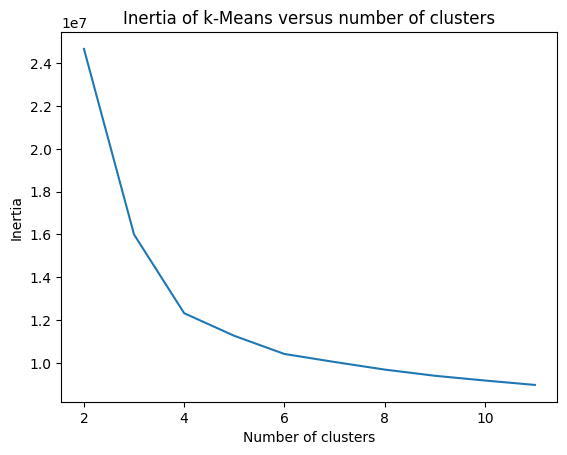

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

# 4.-Clustering-Mean-Shift

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Ejercicio: Probar con varios)

In [ ]:
ms = MeanShift(bandwidth=1, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 4747


Graficamos los resultados:

In [ ]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[14]

In [ ]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

In [ ]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  5 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN, ANÁLISIS: Análisis exploratorio de los clusters, usando las clases/clusters asignadas por MeanShift**

In [ ]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Tabla de contingencia kmeans vs meanshift...
#otras ideas?


**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos se pueden hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-subpoblación

In [ ]:
n=10000
df_n=df.loc[:n]
df_n=df_n[(df_n["Position"]!='GK')&(df_n['Overall']>70)]

skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

df_skills=df_n[skills_ratings]


In [ ]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_

In [ ]:
#data=[]
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[15]

In [ ]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

In [ ]:
#en Jupyter:
plot(fig)

# 6.-Clustering-Mean-Shift-subpoblación

In [ ]:
ms = MeanShift(bandwidth=2.01, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)

Numero de clusters encontrado por Mean Shift : 6


In [ ]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[26]
print(skill_1,skill_2)

BallControl Marking


In [ ]:
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

In [ ]:
#En Jupyter
iplot(fig)

In [ ]:
df_clusters=df_skills
df_clusters['kmeans'] = km.labels_ #clusters
df_clusters['MeanShift'] = ms.labels_ #clusters2

In [ ]:
df_clusters.head(5)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,kmeans,MeanShift
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,0,0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,0,2
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,0,0
4,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,0,0
5,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,0,0


**Análisis exploratorio de las clases**